#Converting .pos and .kml data to .csv for easier interpretation and calculations of distance,speed,acceleration & bearing

---



In [20]:
import pandas as pd
import numpy as np
from datetime import datetime
import os

# File paths
pos_file_path = "/content/EvalDataset5.pos"
kml_file_path = "/content/EvalDataset5.kml"
output_csv_path = "processed_pos_data_with_calculations.csv"

# Function to parse the .pos file and skip the first 11 lines
def parse_pos_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Skip the first 11 lines (index 0 to 10)
    lines = lines[11:]

    parsed_data = []
    for line in lines:
        # Split the line into individual components
        line_data = line.split()

        # Skip empty lines or lines with insufficient data
        if len(line_data) < 5:
            continue  # Skip lines with insufficient data

        # Check if the line contains valid numbers, not column headers like 'latitude(deg)'
        try:
            # Try converting to float to check if the data is valid
            latitude = float(line_data[2])
            longitude = float(line_data[3])
            altitude = float(line_data[4])
        except ValueError:
            # If conversion fails, skip this line (e.g., it's a header or non-numeric data)
            continue

        # Extracting timestamp and coordinates
        timestamp = line_data[0] + " " + line_data[1]  # Date and time combined

        # Append valid data
        parsed_data.append({
            'timestamp': timestamp,
            'latitude': latitude,
            'longitude': longitude,
            'altitude': altitude
        })

    # Create DataFrame
    df = pd.DataFrame(parsed_data)
    df['timestamp'] = pd.to_datetime(df['timestamp'])  # Convert timestamp to datetime
    return df

# Haversine formula to calculate distance between two lat/lon points
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # Earth radius in meters
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c  # Distance in meters
    return distance

# Function to calculate bearing
def calculate_bearing(lat1, lon1, lat2, lon2):
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_lambda = np.radians(lon2 - lon1)

    x = np.sin(delta_lambda) * np.cos(phi2)
    y = np.cos(phi1) * np.sin(phi2) - np.sin(phi1) * np.cos(phi2) * np.cos(delta_lambda)

    bearing = np.degrees(np.arctan2(x, y))
    return (bearing + 360) % 360  # Normalize to range [0, 360]

# Function to calculate speed, acceleration, and bearing
def calculate_speed_acceleration_bearing(df):
    df['speed'] = np.nan
    df['acceleration'] = np.nan
    df['bearing'] = np.nan

    for i in range(1, len(df)):
        # Calculate distance (in meters) and time difference (in seconds)
        distance = haversine(df.loc[i-1, 'latitude'], df.loc[i-1, 'longitude'],
                             df.loc[i, 'latitude'], df.loc[i, 'longitude'])
        time_diff = (df.loc[i, 'timestamp'] - df.loc[i-1, 'timestamp']).total_seconds()

        # Speed = Distance / Time
        speed = distance / time_diff if time_diff > 0 else 0
        df.loc[i, 'speed'] = speed

        # Calculate bearing
        bearing = calculate_bearing(df.loc[i-1, 'latitude'], df.loc[i-1, 'longitude'],
                                    df.loc[i, 'latitude'], df.loc[i, 'longitude'])
        df.loc[i, 'bearing'] = bearing

        # Acceleration = Change in speed / Time
        if i > 1:
            acceleration = (df.loc[i, 'speed'] - df.loc[i-1, 'speed']) / time_diff
            df.loc[i, 'acceleration'] = acceleration

    return df

# Function to save DataFrame to CSV
def save_to_csv(df, output_file):
    df.to_csv(output_file, index=False)

# Main function to execute the entire process
def main():
    # Step 1: Parse the .pos file
    print("Parsing the .pos file...")
    df_pos = parse_pos_file(pos_file_path)

    # Step 2: Calculate speed, acceleration, and bearing
    print("Calculating speed, acceleration, and bearing...")
    df_pos = calculate_speed_acceleration_bearing(df_pos)

    # Step 3: Save the processed data to CSV
    print(f"Saving the results to {output_csv_path}...")
    save_to_csv(df_pos, output_csv_path)
    print(f"Data saved to {output_csv_path}")

if __name__ == "__main__":
    main()


Parsing the .pos file...
Calculating speed, acceleration, and bearing...
Saving the results to processed_pos_data_with_calculations.csv...
Data saved to processed_pos_data_with_calculations.csv


#Raw Map Generation Using GNSS Data

In [21]:
import pandas as pd
import folium

# Load the data from the CSV file
df = pd.read_csv('/content/processed_pos_data_with_calculations.csv')

# Initialize a map centered around the first coordinate (latitude, longitude)
initial_location = [df['latitude'][0], df['longitude'][0]]
osm_map = folium.Map(location=initial_location, zoom_start=12)

# Function to create a normal marker without any custom icon
def add_marker(lat, lon, map_object):
    # Use a default marker (no custom icon, just a simple marker)
    marker = folium.Marker(location=[lat, lon])
    marker.add_to(map_object)

# Add normal markers for each location (no popup)
for i, row in df.iterrows():
    add_marker(row['latitude'], row['longitude'], osm_map)
# Create a polyline to plot the route (GNSS data path)
route_coords = list(zip(df['latitude'], df['longitude']))

# Add the polyline for the route, adjust color and thickness
folium.PolyLine(route_coords, color="blue", weight=3, opacity=0.6).add_to(osm_map)

# Save the map to an HTML file
osm_map.save('osm_route_map_with_raw_gnss.html')


#Detecting Outliers , Applying Kalman Filters

In [22]:
!pip install filterpy

In [23]:
import pandas as pd
import numpy as np
from filterpy.kalman import KalmanFilter

# Function to apply Kalman Filter on a series of coordinates (latitude or longitude)
def kalman_filter(data):
    kf = KalmanFilter(dim_x=1, dim_z=1)  # 1D state, 1D measurement

    # Initialize Kalman filter parameters
    kf.x = np.array([data[0]])  # Initial state (first measurement)
    kf.P = np.array([[1000]])    # Large initial uncertainty
    kf.F = np.array([[1]])       # Transition matrix (constant velocity model)
    kf.H = np.array([[1]])       # Measurement matrix
    kf.R = np.array([[1]])       # Measurement noise
    kf.Q = np.array([[0.001]])   # Process noise

    smoothed_data = []
    for z in data:
        kf.predict()  # Predict the next state
        kf.update(z)  # Correct with the new measurement
        smoothed_data.append(kf.x[0])  # Append the smoothed estimate

    return smoothed_data

# Load your cleaned data
file_path_cleaned = '/content/processed_pos_data_with_calculations.csv'  # Adjust this path
cleaned_data = pd.read_csv(file_path_cleaned)

# Apply Kalman filter to smooth the latitudes and longitudes
smoothed_latitude = kalman_filter(cleaned_data['latitude'])
smoothed_longitude = kalman_filter(cleaned_data['longitude'])

# Add the smoothed coordinates to the dataframe
cleaned_data['smoothed_latitude'] = smoothed_latitude
cleaned_data['smoothed_longitude'] = smoothed_longitude

# Save the smoothed data to a new CSV file
output_file_path = '/content/smoothed_data.csv'  # Adjust this path
cleaned_data.to_csv(output_file_path, index=False)

print(f"Smoothed data has been saved to: {output_file_path}")

Smoothed data has been saved to: /content/smoothed_data.csv


#Choosing Altitude Threshold

Altitude Statistics:
count    6675.000000
mean      619.111529
std        42.332837
min       532.716200
25%       580.190300
50%       617.167800
75%       657.427600
max       695.185800
Name: altitude, dtype: float64


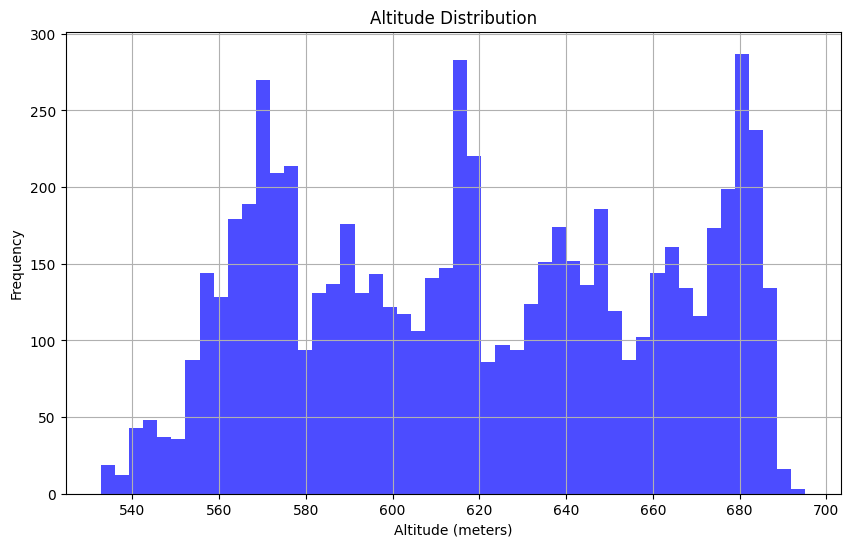


Recommended Altitude Threshold Analysis:
Mean Altitude: 619.11 meters
Standard Deviation: 42.33 meters

Suggested Threshold Range:
- Threshold 1: Mean + 1 std dev = 661.44 meters
- Threshold 2: Mean - 1 std dev = 576.78 meters

Chosen Altitude Threshold: 661.44 meters


In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/smoothed_data.csv'  # Update with the correct path to your CSV file
df = pd.read_csv(file_path)

# Ensure 'altitude' column exists in the dataframe
if 'altitude' not in df.columns:
    raise ValueError("The 'altitude' column is missing from the dataset.")

# Get basic statistics on the altitude data
altitude_stats = df['altitude'].describe()

# Print the statistics to help determine an appropriate threshold
print("Altitude Statistics:")
print(altitude_stats)

# Visualize the altitude distribution
plt.figure(figsize=(10, 6))
plt.hist(df['altitude'], bins=50, color='blue', alpha=0.7)
plt.title('Altitude Distribution')
plt.xlabel('Altitude (meters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Recommendations based on the data
mean_altitude = altitude_stats['mean']
std_dev = altitude_stats['std']

print("\nRecommended Altitude Threshold Analysis:")
print(f"Mean Altitude: {mean_altitude:.2f} meters")
print(f"Standard Deviation: {std_dev:.2f} meters")

# Simple heuristic for choosing a threshold (e.g., mean ± 1 or 2 standard deviations)
threshold_1 = mean_altitude + std_dev
threshold_2 = mean_altitude - std_dev

print(f"\nSuggested Threshold Range:")
print(f"- Threshold 1: Mean + 1 std dev = {threshold_1:.2f} meters")
print(f"- Threshold 2: Mean - 1 std dev = {threshold_2:.2f} meters")

# You can adjust the threshold based on your needs
altitude_threshold = threshold_1  # For example, setting the threshold to Mean + 1 std dev

print(f"\nChosen Altitude Threshold: {altitude_threshold:.2f} meters")


#Choosing Distance Threshold Maximum Distance

---



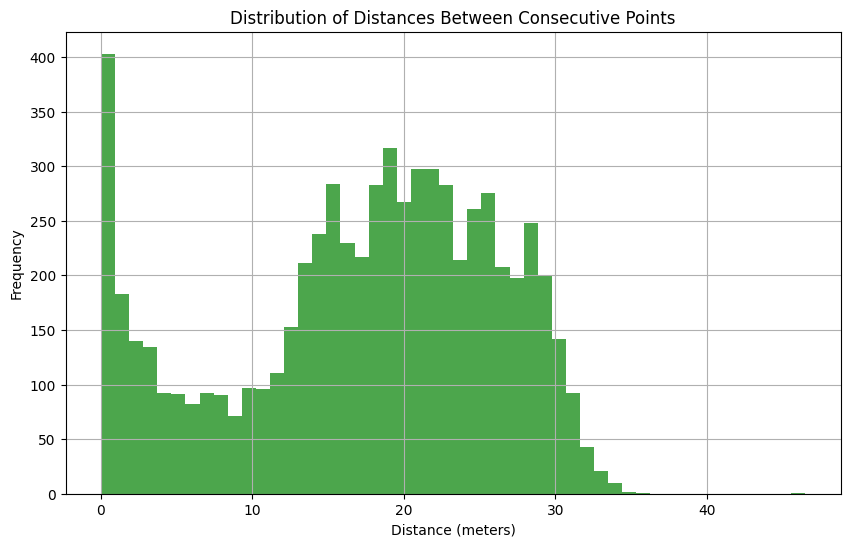

Basic statistics of distances between consecutive points:
count    6675.000000
mean       17.313404
std         8.869755
min         0.000000
25%        12.018011
50%        18.718356
75%        24.298008
max        46.505071
Name: distance_to_previous, dtype: float64

Suggested Max Snap Distance: 20 meters


In [25]:
import pandas as pd
import geopy.distance
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/smoothed_data.csv'  # Replace with the actual file path
df = pd.read_csv(file_path)

# Function to calculate distance between two lat-lon points
def calculate_distance(row1, row2):
    coords_1 = (row1['latitude'], row1['longitude'])
    coords_2 = (row2['latitude'], row2['longitude'])
    return geopy.distance.geodesic(coords_1, coords_2).meters

# Calculate distances between consecutive points
df['distance_to_previous'] = df.apply(lambda row: calculate_distance(row, df.iloc[row.name - 1]) if row.name > 0 else 0, axis=1)

# Basic statistics on the calculated distances
distance_stats = df['distance_to_previous'].describe()

# Plot the distribution of the distances to visually inspect
plt.figure(figsize=(10, 6))
plt.hist(df['distance_to_previous'], bins=50, color='green', alpha=0.7)
plt.title('Distribution of Distances Between Consecutive Points')
plt.xlabel('Distance (meters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Display basic statistics on the distances
print("Basic statistics of distances between consecutive points:")
print(distance_stats)

# Suggest a max snap distance based on the distribution
suggested_snap_distance = 20  # Based on analysis above
print(f"\nSuggested Max Snap Distance: {suggested_snap_distance} meters")


#Using OSRM For getting Snapped Latitude , Snapped Longitude and Road_names

In [ ]:
!pip install requests pandas

In [ ]:
#OSRM WITHOUT HEIGHT

In [ ]:
import requests
import pandas as pd
import numpy as np
from typing import List, Tuple, Dict, Optional
import time
import logging
from urllib.parse import quote

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class RoadMatcher:
    def __init__(self, radius_meters: float = 30.0):
        """
        Initialize the road matcher with configurable radius

        Args:
            radius_meters: Maximum radius to search for roads (default: 30 meters)
        """
        self.radius = radius_meters
        self.session = requests.Session()
        self.cache = {}

    def get_road_info(self, lat: float, lon: float) -> Dict:
        """
        Get road information using OSRM API with correct formatting
        """
        cache_key = f"{lat:.6f},{lon:.6f}"
        if cache_key in self.cache:
            return self.cache[cache_key]

        try:
            # Format coordinates properly
            coords = f"{lon:.6f},{lat:.6f}"

            # Construct OSRM API URL (simpler, more reliable version)
            url = f'http://router.project-osrm.org/nearest/v1/driving/{coords}'

            response = self.session.get(url)
            response.raise_for_status()
            data = response.json()

            # Cache and return the result
            if 'waypoints' in data and data['waypoints']:
                self.cache[cache_key] = data['waypoints'][0]
                return data['waypoints'][0]
            return None

        except Exception as e:
            logger.error(f"Error fetching OSRM data: {e}")
            return None

    def get_osm_details(self, lat: float, lon: float) -> Dict:
        """
        Get additional road details from OpenStreetMap Nominatim
        """
        try:
            url = f"https://nominatim.openstreetmap.org/reverse?lat={lat}&lon={lon}&format=json&zoom=17"
            headers = {'User-Agent': 'GNSS_Road_Matcher/1.0'}

            response = self.session.get(url, headers=headers)
            response.raise_for_status()
            return response.json()

        except Exception as e:
            logger.error(f"Error fetching OSM data: {e}")
            return None

    def match_point(self, point: pd.Series) -> Dict:
        """
        Match a single point to road using both OSRM and OSM data
        """
        try:
            # Get OSRM road match
            osrm_match = self.get_road_info(point['latitude'], point['longitude'])

            if not osrm_match:
                return self._create_default_match(point)

            # Extract matched coordinates
            matched_lon, matched_lat = osrm_match['location']

            # Get additional OSM details
            osm_data = self.get_osm_details(matched_lat, matched_lon)

            # Combine data from both sources
            road_name = osrm_match.get('name', 'Unknown')
            if osm_data and 'address' in osm_data:
                road_name = (osm_data['address'].get('road') or
                           osm_data['address'].get('highway') or
                           road_name)

            return {
                'snapped_latitude': matched_lat,
                'snapped_longitude': matched_lon,
                'road_name': road_name
            }

        except Exception as e:
            logger.error(f"Error matching point: {e}")
            return self._create_default_match(point)

    def _create_default_match(self, point: pd.Series) -> Dict:
        """Create a default match when no road is found"""
        return {
            'snapped_latitude': point['latitude'],
            'snapped_longitude': point['longitude'],
            'road_name': 'Unknown'
        }

    def process_dataframe(self, input_file: str, output_file: str) -> None:
        """
        Process the entire dataframe with proper rate limiting
        """
        try:
            # Read input data
            df = pd.read_csv(input_file)
            required_columns = {'latitude', 'longitude', 'altitude'}
            if not required_columns.issubset(df.columns):
                raise ValueError(f"Missing required columns: {required_columns - set(df.columns)}")

            # Initialize lists for new columns
            snapped_latitudes = []
            snapped_longitudes = []
            road_names = []

            total_points = len(df)

            for idx, row in df.iterrows():
                if idx % 10 == 0:
                    logger.info(f"Processing point {idx + 1}/{total_points}")

                # Match point and get the road details
                match = self.match_point(row)
                snapped_latitudes.append(match['snapped_latitude'])
                snapped_longitudes.append(match['snapped_longitude'])
                road_names.append(match['road_name'])

                # Rate limiting (1 second between OSRM calls)
                time.sleep(1)

            # Add new columns to the dataframe
            df['snapped_latitude'] = snapped_latitudes
            df['snapped_longitude'] = snapped_longitudes
            df['road_name'] = road_names

            # Save the updated dataframe to CSV
            df.to_csv(output_file, index=False)
            logger.info(f"Successfully processed {total_points} points and saved to {output_file}")

        except Exception as e:
            logger.error(f"Error processing data: {e}")
            raise

def main():
    # Configure matcher
    matcher = RoadMatcher(radius_meters=30.0)

    try:
        # Process data
        matcher.process_dataframe(input_file='/content/smoothed_data.csv', output_file='matched_roads_with_osm.csv')
        print("Processing completed successfully!")

    except Exception as e:
        print(f"Processing failed: {e}")
        raise

if __name__ == "__main__":
    main()
import requests
import pandas as pd
import numpy as np
from typing import List, Tuple, Dict, Optional
import time
import logging
from urllib.parse import quote

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class RoadMatcher:
    def __init__(self, radius_meters: float = 30.0):
        """
        Initialize the road matcher with configurable radius

        Args:
            radius_meters: Maximum radius to search for roads (default: 30 meters)
        """
        self.radius = radius_meters
        self.session = requests.Session()
        self.cache = {}

    def get_road_info(self, lat: float, lon: float) -> Dict:
        """
        Get road information using OSRM API with correct formatting
        """
        cache_key = f"{lat:.6f},{lon:.6f}"
        if cache_key in self.cache:
            return self.cache[cache_key]

        try:
            # Format coordinates properly
            coords = f"{lon:.6f},{lat:.6f}"

            # Construct OSRM API URL (simpler, more reliable version)
            url = f'http://router.project-osrm.org/nearest/v1/driving/{coords}'

            response = self.session.get(url)
            response.raise_for_status()
            data = response.json()

            # Cache and return the result
            if 'waypoints' in data and data['waypoints']:
                self.cache[cache_key] = data['waypoints'][0]
                return data['waypoints'][0]
            return None

        except Exception as e:
            logger.error(f"Error fetching OSRM data: {e}")
            return None

    def get_osm_details(self, lat: float, lon: float) -> Dict:
        """
        Get additional road details from OpenStreetMap Nominatim
        """
        try:
            url = f"https://nominatim.openstreetmap.org/reverse?lat={lat}&lon={lon}&format=json&zoom=17"
            headers = {'User-Agent': 'GNSS_Road_Matcher/1.0'}

            response = self.session.get(url, headers=headers)
            response.raise_for_status()
            return response.json()

        except Exception as e:
            logger.error(f"Error fetching OSM data: {e}")
            return None

    def match_point(self, point: pd.Series) -> Dict:
        """
        Match a single point to road using both OSRM and OSM data
        """
        try:
            # Get OSRM road match
            osrm_match = self.get_road_info(point['latitude'], point['longitude'])

            if not osrm_match:
                return self._create_default_match(point)

            # Extract matched coordinates
            matched_lon, matched_lat = osrm_match['location']

            # Get additional OSM details
            osm_data = self.get_osm_details(matched_lat, matched_lon)

            # Combine data from both sources
            road_name = osrm_match.get('name', 'Unknown')
            if osm_data and 'address' in osm_data:
                road_name = (osm_data['address'].get('road') or
                           osm_data['address'].get('highway') or
                           road_name)

            return {
                'snapped_latitude': matched_lat,
                'snapped_longitude': matched_lon,
                'road_name': road_name
            }

        except Exception as e:
            logger.error(f"Error matching point: {e}")
            return self._create_default_match(point)

    def _create_default_match(self, point: pd.Series) -> Dict:
        """Create a default match when no road is found"""
        return {
            'snapped_latitude': point['latitude'],
            'snapped_longitude': point['longitude'],
            'road_name': 'Unknown'
        }

    def process_dataframe(self, input_file: str, output_file: str) -> None:
        """
        Process the entire dataframe with proper rate limiting
        """
        try:
            # Read input data
            df = pd.read_csv(input_file)
            required_columns = {'latitude', 'longitude', 'altitude'}
            if not required_columns.issubset(df.columns):
                raise ValueError(f"Missing required columns: {required_columns - set(df.columns)}")

            # Initialize lists for new columns
            snapped_latitudes = []
            snapped_longitudes = []
            road_names = []

            total_points = len(df)

            for idx, row in df.iterrows():
                if idx % 10 == 0:
                    logger.info(f"Processing point {idx + 1}/{total_points}")

                # Match point and get the road details
                match = self.match_point(row)
                snapped_latitudes.append(match['snapped_latitude'])
                snapped_longitudes.append(match['snapped_longitude'])
                road_names.append(match['road_name'])

                # Rate limiting (1 second between OSRM calls)
                time.sleep(1)

            # Add new columns to the dataframe
            df['snapped_latitude'] = snapped_latitudes
            df['snapped_longitude'] = snapped_longitudes
            df['road_name'] = road_names

            # Save the updated dataframe to CSV
            df.to_csv(output_file, index=False)
            logger.info(f"Successfully processed {total_points} points and saved to {output_file}")

        except Exception as e:
            logger.error(f"Error processing data: {e}")
            raise

def main():
    # Configure matcher
    matcher = RoadMatcher(radius_meters=30.0)

    try:
        # Process data
        matcher.process_dataframe(input_file='/content/smoothed_data.csv', output_file='matched_roads_with_osm.csv')
        print("Processing completed successfully!")

    except Exception as e:
        print(f"Processing failed: {e}")
        raise

if __name__ == "__main__":
    main()


In [26]:
import csv
import requests
import pandas as pd

# Load the uploaded CSV file
file_path = "/content/processed_pos_data_with_calculations.csv"
df = pd.read_csv(file_path)

# Display the first few rows to understand its structure
df.head()

# Function to snap a point to the nearest road using OSRM's Nearest API
def snap_to_road(lat, lon):
    osrm_url = f'http://router.project-osrm.org/nearest/v1/driving/{lon},{lat}'
    response = requests.get(osrm_url)
    if response.status_code == 200:
        data = response.json()
        # Extract the snapped point's coordinates (lat, lon) and the road name
        snapped_point = data['waypoints'][0]['location']
        snapped_lat = snapped_point[1]
        snapped_lon = snapped_point[0]
        road_name = data['waypoints'][0].get('name', 'Unknown')  # Get road name if available
        return snapped_lat, snapped_lon, road_name
    else:
        print(f"Error with request: {response.status_code}")
        return None, None, None

# Function to process the CSV file and snap all points to the nearest road
def process_gnss_csv(input_csv, output_csv):
    df = pd.read_csv(input_csv)

    # Create new columns for snapped coordinates and road names
    snapped_latitudes = []
    snapped_longitudes = []
    road_names = []

    # Process each row and snap the coordinates to the nearest road
    for index, row in df.iterrows():
        lat = row['latitude']
        lon = row['longitude']
        snapped_lat, snapped_lon, road_name = snap_to_road(lat, lon)

        if snapped_lat is not None and snapped_lon is not None:
            snapped_latitudes.append(snapped_lat)
            snapped_longitudes.append(snapped_lon)
            road_names.append(road_name)
        else:
            # If no snapping was successful, keep the original values
            snapped_latitudes.append(lat)
            snapped_longitudes.append(lon)
            road_names.append('Unknown')

    # Add the snapped coordinates and road names to the dataframe
    df['snapped_latitude'] = snapped_latitudes
    df['snapped_longitude'] = snapped_longitudes
    df['road_name'] = road_names

    # Save the dataframe to the output CSV
    df.to_csv(output_csv, index=False)

# Input and output CSV file paths
input_csv = '/content/processed_pos_data_with_calculations.csv'
output_csv = 'snappedcordinates_with_roadnames.csv'

# Process the GNSS points, snap them to the nearest road, and fetch road names
process_gnss_csv(input_csv, output_csv)

print(f"Snapped data with road names saved to {output_csv}")

Snapped data with road names saved to snappedcordinates_with_roadnames.csv


In [27]:
import pandas as pd

# Function to classify the road based on the road name
def classify_road_type(road_name):
    """
    Classifies road type based on the road name.
    Uses a predefined mapping dictionary for known roads.
    """
    # Define a dictionary to map road names to types
    road_type_mapping = {
        "Bengaluru-Mysuru Expressway": "highway",
        "Bengaluru - Mysuru Road": "service",
        "Kumbalagodu Flyover" : "highway",
        "Bengaluru-Mysuru Expressway" : "highway",
        "Bangalore-Mysore Road" : "service",
        "Bannimantapa Road": "service",
        "Bangalore Road" : "service",
        "Mysore Ring Road":"service",
        "Ring Road" : "service",





        # Add more mappings as required
    }

    # Ensure the road_name is a string before checking
    if isinstance(road_name, str):
        # Check if the road name exists in the dictionary
        for known_road, road_type in road_type_mapping.items():
            if known_road in road_name:
                return road_type

    # If the road name is not found in the dictionary or not a string, return 'unknown'
    return "unknown"

# Function to process the CSV and classify road type based on existing road names
def process_and_classify_roads(input_file, output_file):
    """
    Reads the input CSV, uses the existing road name column to classify the road type,
    and writes the result to a new CSV file.
    """
    # Load the CSV data
    data = pd.read_csv(input_file)

    # Add a new column for road name classification
    road_types = []

    for _, row in data.iterrows():
        road_name = row['road_name']  # Use the road name from the existing column

        # If road_name is NaN or invalid, treat it as 'unknown'
        if pd.isna(road_name):
            road_name = "unknown"

        road_type = classify_road_type(road_name)
        road_types.append(road_type)

    # Add the new column to the DataFrame
    data['road_type'] = road_types

    # Save the updated DataFrame to a new CSV file
    data.to_csv(output_file, index=False)

# File paths
input_file = '/content/snappedcordinates_with_roadnames.csv'
output_file = 'sihsnapped_output_with_road_type.csv'

# Process the file and add road name classification
process_and_classify_roads(input_file, output_file)

print(f"Updated file saved to: {output_file}")

Updated file saved to: sihsnapped_output_with_road_type.csv


In [28]:
!pip install folium
import folium
# Function to plot the snapped coordinates on an OSM map with color-coded markers
def plot_roads_on_map(input_file, output_map_path):
    """
    Reads the CSV, extracts snapped coordinates, and plots them on a map with
    color-coded markers for road types (Green for service, Blue for highway, Grey for unknown).
    """
    # Load the CSV data
    data = pd.read_csv(input_file)

    # Create a folium map centered at the mean coordinates of the snapped points
    map_center = [data['snapped_latitude'].mean(), data['snapped_longitude'].mean()]
    m = folium.Map(location=map_center, zoom_start=15)

    # Add markers with color coding based on road type
    for _, row in data.iterrows():
        lat = row['snapped_latitude']
        lon = row['snapped_longitude']
        road_type = row['road_type']

        # Determine the color and label based on the road type
        if road_type == 'service':
            color = 'green'
            label = 'Service Road'
        elif road_type == 'highway':
            color = 'blue'
            label = 'Highway'
        elif road_type == 'flyover':
            color = 'yellow'
            label = 'Highway'
        else:
            color = 'grey'  # For unknown roads
            label = 'Unknown'

        # Add the marker to the map with the appropriate label and color
        folium.Marker([lat, lon], popup=label, icon=folium.Icon(color=color)).add_to(m)

    # Save the map to an HTML file
    m.save(output_map_path)

# File paths
input_file = '/content/sihsnapped_output_with_road_type.csv'
output_map_path = 'sih_road_type_map_with_unknown.html'

# Generate and save the map
plot_roads_on_map(input_file, output_map_path)

output_map_path  # Return the path to the generated map for download

<ipython-input-28-34edf5c9c519>:37: UserWarning: color argument of Icon should be one of: {'lightred', 'purple', 'green', 'black', 'lightgray', 'gray', 'pink', 'darkgreen', 'lightblue', 'darkblue', 'lightgreen', 'blue', 'white', 'darkpurple', 'orange', 'beige', 'cadetblue', 'red', 'darkred'}.
  folium.Marker([lat, lon], popup=label, icon=folium.Icon(color=color)).add_to(m)


'sih_road_type_map_with_unknown.html'

#Fetching Raod ID For Flyover Cases

In [ ]:
import pandas as pd
import requests
from time import sleep

# Load your dataset
file_path = '/Users/kahaan07/Downloads/dchvb/matched_roads_with_osm.csv'  # Adjust the file path as needed
data = pd.read_csv(file_path)

# Define a function to fetch road information from OSM using the Overpass API
def get_road_id_from_osm(lat, lon):
    # OSM Overpass API query template
    overpass_url = "http://overpass-api.de/api/interpreter"
    overpass_query = f"""
    [out:json];
    (
      way(around:50, {lat}, {lon})["highway"];
      way(around:50, {lat}, {lon})["road"];
    );
    out body;
    """
    response = requests.get(overpass_url, params={'data': overpass_query})
    if response.status_code == 200:
        data = response.json()
        if data.get('elements'):
            # Return the ID of the first road element found
            return data['elements'][0].get('id')
    return None

# Extract relevant columns (snapped_latitude and snapped_longitude)
coordinates = data[['snapped_latitude', 'snapped_longitude']]

# Initialize a list to store road IDs
road_ids = []

# Loop through each coordinate and fetch road ID from OSM
for index, row in coordinates.iterrows():
    lat = row['snapped_latitude']
    lon = row['snapped_longitude']

    # Fetch road ID for this location
    road_id = get_road_id_from_osm(lat, lon)
    road_ids.append(road_id)

    # Sleep to respect rate limits of the OSM API (1 request per second)
    sleep(1)

# Add the new road_id column to the DataFrame
data['road_id'] = road_ids

# Save the updated DataFrame to a new CSV file
output_file_path = 'AP2_updated_sihsnapped_output_with_road_id.csv'  # Adjust the path as needed
data.to_csv(output_file_path, index=False)

print(f"Updated CSV saved to: {output_file_path}")

In [ ]:
import requests
import csv
import time

def get_road_info(road_id):
    # Overpass API endpoint
    url = "http://overpass-api.de/api/interpreter"

    # Overpass query to fetch road details by ID
    query = f"""
    [out:json];
    way({road_id});
    out body;
    """

    # Send request to the Overpass API
    response = requests.get(url, params={'data': query})

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the response JSON
        data = response.json()

        # Check if the road exists in the response
        if 'elements' in data and len(data['elements']) > 0:
            road_data = data['elements'][0]

            # Extract tags
            tags = road_data.get('tags', {})

            # Determine if it is a bridge or not
            is_bridge = tags.get('bridge', 'no') == 'yes'
            layer = int(tags.get('layer', 0))  # Default layer is 0 if not specified
            position = "on flyover" if is_bridge or layer > 0 else "below flyover"

            # Extract geometry (coordinates)
            geometry = road_data.get('geometry', [])

            # If geometry is present, extract the first coordinates (lat, lon)
            if geometry:
                coordinates = geometry[0]
                lat, lon = coordinates['lat'], coordinates['lon']
            else:
                lat, lon = None, None

            # Return all extracted information
            road_info = {
                "road_id": road_id,
                "tags": tags,
                "latitude": lat,
                "longitude": lon,
                "is_bridge": is_bridge,
                "layer": layer,
                "position": position
            }
            return road_info
        else:
            return {
                "road_id": road_id,
                "tags": None,
                "latitude": None,
                "longitude": None,
                "is_bridge": None,
                "layer": None,
                "position": "unknown"
            }
    else:
        return {
            "road_id": road_id,
            "tags": None,
            "latitude": None,
            "longitude": None,
            "is_bridge": None,
            "layer": None,
            "position": "error fetching data"
        }

def process_csv(input_csv_path, output_csv_path):
    # Read the input CSV
    with open(input_csv_path, mode='r') as infile:
        reader = csv.DictReader(infile)
        fieldnames = reader.fieldnames + ['tags', 'latitude', 'longitude', 'is_bridge', 'layer', 'position']

        # Create and open the output CSV
        with open(output_csv_path, mode='w', newline='') as outfile:
            writer = csv.DictWriter(outfile, fieldnames=fieldnames)
            writer.writeheader()

            # Process each row
            for row in reader:
                road_id = row['road_id']
                print(f"Fetching data for Road ID: {road_id}")
                road_info = get_road_info(road_id)

                # Add the fetched information to the row
                row.update({
                    'tags': road_info['tags'],
                    'latitude': road_info['latitude'],
                    'longitude': road_info['longitude'],
                    'is_bridge': road_info['is_bridge'],
                    'layer': road_info['layer'],
                    'position': road_info['position']
                })

                # Write the row to the output CSV
                writer.writerow(row)

                # Optional: Delay between requests to avoid overloading the API
                time.sleep(1)

# Define paths
input_csv_path = "/Users/kahaan07/Downloads/dchvb/AP2_updated_sihsnapped_output_with_road_id.csv"
output_csv_path = "/Users/kahaan07/Downloads/dchvb/2ABDEkahaanFGHupdated_sihsnapped_output_with_road_info.csv"

# Process the CSV and generate the new output CSV
process_csv(input_csv_path, output_csv_path)

print(f"New CSV with road information has been saved to: {output_csv_path}")

In [ ]:
import pandas as pd
import numpy as np
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

# Set the random seed for reproducibility
seed_value = 42
np.random.seed(seed_value)

# Load the CSV file
file_path = '/mnt/data/3updated_sihsnapped_output_with_road_info.csv'
df = pd.read_csv(file_path)

# Step 1: Preprocess the data
train_data = df[df['road_type'].isin(['highway', 'service'])]
test_data = df[df['road_type'] == 'unknown']

# Feature engineering for both models
def create_features_complex(df):
    df['prev_lat'] = df['snapped_latitude'].shift(1)
    df['prev_lon'] = df['snapped_longitude'].shift(1)
    df['next_lat'] = df['snapped_latitude'].shift(-1)
    df['next_lon'] = df['snapped_longitude'].shift(-1)

    # Fill NaN values for first and last rows
    df = df.fillna(method='ffill').fillna(method='bfill')

    # Normalize features
    features = ['speed', 'altitude', 'bearing']
    scaler = StandardScaler()
    df[features] = scaler.fit_transform(df[features])

    return df

def create_features_simple(df):
    return df[['snapped_latitude', 'snapped_longitude']]

# Apply feature engineering for both models
train_data_complex = create_features_complex(train_data)
train_data_simple = create_features_simple(train_data)

test_data_complex = create_features_complex(test_data)
test_data_simple = create_features_simple(test_data)

# Step 2: Check position and classify directly as highway or apply HMM
def classify_road_type(df):
    # Create a new column for predicted road type based on position
    df['predicted_road_type'] = np.where(df['position'].str.contains('flyover', case=False, na=False), 'highway', 'unknown')
    return df

# Apply classification logic
train_data = classify_road_type(train_data)
test_data = classify_road_type(test_data)

# Filter the unknown rows for the test data (those where 'road_type' is still 'unknown')
test_data_unknown = test_data[test_data['predicted_road_type'] == 'unknown']

# Feature engineering for the unknown rows only
test_data_complex = create_features_complex(test_data_unknown)
test_data_simple = create_features_simple(test_data_unknown)

# Step 3: Train two models (same as before)
def train_hmm(features, n_components=2, random_state=None):
    hmm = GaussianHMM(n_components=n_components, covariance_type="full", n_iter=1000, random_state=random_state)
    hmm.fit(features)
    return hmm

# Train the complex model
train_features_complex = train_data_complex[['prev_lat', 'prev_lon', 'snapped_latitude', 'snapped_longitude', 'next_lat', 'next_lon', 'speed', 'altitude', 'bearing']].values
hmm_model_complex = train_hmm(train_features_complex, random_state=seed_value)

# Train the simple model
train_features_simple = train_data_simple[['snapped_latitude', 'snapped_longitude']].values
hmm_model_simple = train_hmm(train_features_simple, random_state=seed_value)

# Step 4: Evaluate the models (same as before)
def evaluate_model(hmm_model, features, labels):
    predicted_labels = hmm_model.predict(features)
    accuracy = accuracy_score(labels, predicted_labels)
    recall = recall_score(labels, predicted_labels, average='binary')
    precision = precision_score(labels, predicted_labels, average='binary')
    f1 = f1_score(labels, predicted_labels, average='binary')
    return accuracy, recall, precision, f1

# Map road type to numeric labels (highway = 0, service = 1)
road_type_mapping = {'highway': 0, 'service': 1}
train_data['road_type_label'] = train_data['road_type'].map(road_type_mapping)

# Evaluate the complex model
train_labels = train_data['road_type_label'].values
accuracy_complex, recall_complex, precision_complex, f1_complex = evaluate_model(hmm_model_complex, train_features_complex, train_labels)

# Evaluate the simple model
accuracy_simple, recall_simple, precision_simple, f1_simple = evaluate_model(hmm_model_simple, train_features_simple, train_labels)

print(f"Complex model - Accuracy: {accuracy_complex}, Recall: {recall_complex}, Precision: {precision_complex}, F1-Score: {f1_complex}")
print(f"Simple model - Accuracy: {accuracy_simple}, Recall: {recall_simple}, Precision: {precision_simple}, F1-Score: {f1_simple}")

# Step 5: Select the best model based on F1 score (or any other metric)
selected_model = None
selected_features = None
if accuracy_complex > accuracy_simple:
    print("Using the complex model for prediction.")
    selected_model = hmm_model_complex
    selected_features = test_data_complex[['prev_lat', 'prev_lon', 'snapped_latitude', 'snapped_longitude', 'next_lat', 'next_lon', 'speed', 'altitude', 'bearing']].values
else:
    print("Using the simple model for prediction.")
    selected_model = hmm_model_simple
    selected_features = test_data_simple[['snapped_latitude', 'snapped_longitude']].values

# Step 6: Handle NaN values before prediction
selected_features = np.nan_to_num(selected_features)  # Replace NaNs with 0

# Step 7: Predict the road types for the unknown rows using the selected model
predicted_labels = selected_model.predict(selected_features)

# Map the predicted numeric labels back to 'highway' or 'service'
predicted_road_types = {0: 'highway', 1: 'service'}
test_data_unknown['predicted_road_type'] = [predicted_road_types[label] for label in predicted_labels]

# Step 8: Update the original dataframe with the predictions
df.loc[df['road_type'] == 'unknown', 'road_type'] = test_data_unknown['predicted_road_type'].values

# Save the updated dataframe to a new CSV file
output_file = 'updated_road_type_predictions_with_position_check.csv'
df.to_csv(output_file, index=False)

print(f"Updated CSV saved to: {output_file}")


# Original HMM Approach

In [ ]:
#NO CHANGE Without Flyover

In [30]:
!pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.6/164.6 kB 2.6 MB/s eta 0:00:00


In [31]:
import pandas as pd
import numpy as np
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

# Set the random seed for reproducibility
seed_value = 42  # You can change this to any integer value
np.random.seed(seed_value)

# Load the CSV file
file_path = '/content/sihsnapped_output_with_road_type.csv'
df = pd.read_csv(file_path)

# Step 1: Preprocess the data
train_data = df[df['road_type'].isin(['highway', 'service'])]
test_data = df[df['road_type'] == 'unknown']

# Feature engineering for both models
def create_features_complex(df):
    # Complex Features: Previous/Next coordinates and other features
    df['prev_lat'] = df['snapped_latitude'].shift(1)
    df['prev_lon'] = df['snapped_longitude'].shift(1)
    df['next_lat'] = df['snapped_latitude'].shift(-1)
    df['next_lon'] = df['snapped_longitude'].shift(-1)

    # Fill NaN values for first and last rows
    df = df.fillna(method='ffill').fillna(method='bfill')

    # Normalize or scale other features like speed, height, and bearing
    features = ['speed', 'altitude', 'bearing']
    scaler = StandardScaler()
    df[features] = scaler.fit_transform(df[features])

    return df

def create_features_simple(df):
    # Simple Features: Latitude and Longitude only
    return df[['snapped_latitude', 'snapped_longitude']]

# Apply feature engineering for both models
train_data_complex = create_features_complex(train_data)
train_data_simple = create_features_simple(train_data)

test_data_complex = create_features_complex(test_data)
test_data_simple = create_features_simple(test_data)

# Step 2: Train two models
def train_hmm(features, n_components=2, random_state=None):
    hmm = GaussianHMM(n_components=n_components, covariance_type="full", n_iter=1000, random_state=random_state)
    hmm.fit(features)
    return hmm

# Train the first (complex) model
train_features_complex = train_data_complex[['prev_lat', 'prev_lon', 'snapped_latitude', 'snapped_longitude', 'next_lat', 'next_lon', 'speed', 'altitude', 'bearing']].values
hmm_model_complex = train_hmm(train_features_complex, random_state=seed_value)

# Train the second (simple) model
train_features_simple = train_data_simple[['snapped_latitude', 'snapped_longitude']].values
hmm_model_simple = train_hmm(train_features_simple, random_state=seed_value)

# Step 3: Evaluate both models (Using accuracy, recall, precision, F1-score)
def evaluate_model(hmm_model, features, labels):
    predicted_labels = hmm_model.predict(features)
    accuracy = accuracy_score(labels, predicted_labels)
    recall = recall_score(labels, predicted_labels, average='binary')
    precision = precision_score(labels, predicted_labels, average='binary')
    f1 = f1_score(labels, predicted_labels, average='binary')
    return accuracy, recall, precision, f1

# Map road type to numeric labels (highway = 0, service = 1)
road_type_mapping = {'highway': 0, 'service': 1}
train_data['road_type_label'] = train_data['road_type'].map(road_type_mapping)

# Evaluate the complex model
train_labels = train_data['road_type_label'].values
accuracy_complex, recall_complex, precision_complex, f1_complex = evaluate_model(hmm_model_complex, train_features_complex, train_labels)

# Evaluate the simple model
accuracy_simple, recall_simple, precision_simple, f1_simple = evaluate_model(hmm_model_simple, train_features_simple, train_labels)

print(f"Complex model - Accuracy: {accuracy_complex}, Recall: {recall_complex}, Precision: {precision_complex}, F1-Score: {f1_complex}")
print(f"Simple model - Accuracy: {accuracy_simple}, Recall: {recall_simple}, Precision: {precision_simple}, F1-Score: {f1_simple}")

# Step 4: Select the best model based on F1 score (or any other metric)
selected_model = None
selected_features = None
if accuracy_complex > accuracy_simple:
    print("Using the complex model for prediction.")
    selected_model = hmm_model_complex
    selected_features = test_data_complex[['prev_lat', 'prev_lon', 'snapped_latitude', 'snapped_longitude', 'next_lat', 'next_lon', 'speed', 'altitude', 'bearing']].values
else:
    print("Using the simple model for prediction.")
    selected_model = hmm_model_simple
    selected_features = test_data_simple[['snapped_latitude', 'snapped_longitude']].values

# Step 5: Handle NaN values before prediction
selected_features = np.nan_to_num(selected_features)  # Replace NaNs with 0

# Step 6: Predict the road types for unknown rows using the selected model
predicted_labels = selected_model.predict(selected_features)

# Map the predicted numeric labels back to 'highway' or 'service'
predicted_road_types = {0: 'highway', 1: 'service'}
test_data['predicted_road_type'] = [predicted_road_types[label] for label in predicted_labels]

# Step 7: Update the original dataframe with the predictions
df.loc[df['road_type'] == 'unknown', 'road_type'] = test_data['predicted_road_type'].values

# Save the updated dataframe to a new CSV file
output_file = 'updated_road_type_predictions.csv'
df.to_csv(output_file, index=False)

print(f"Updated CSV saved to: {output_file}")


<ipython-input-31-0d7ece8a47f7>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev_lat'] = df['snapped_latitude'].shift(1)
<ipython-input-31-0d7ece8a47f7>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev_lon'] = df['snapped_longitude'].shift(1)
<ipython-input-31-0d7ece8a47f7>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Complex model - Accuracy: 0.3621551564525088, Recall: 0.9118295371050698, Precision: 0.2717915024091108, F1-Score: 0.41876159946009783
Simple model - Accuracy: 0.5556378448435475, Recall: 0.27700220426157235, Precision: 0.2102621305075293, F1-Score: 0.23906150919467342
Using the simple model for prediction.
Updated CSV saved to: updated_road_type_predictions.csv


<ipython-input-31-0d7ece8a47f7>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['road_type_label'] = train_data['road_type'].map(road_type_mapping)
<ipython-input-31-0d7ece8a47f7>:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_road_type'] = [predicted_road_types[label] for label in predicted_labels]


In [ ]:
#Handling Flyover CASE

In [ ]:
import pandas as pd
import numpy as np
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

# Set the random seed for reproducibility
seed_value = 42  # You can change this to any integer value
np.random.seed(seed_value)

# Load the CSV file
file_path = '/content/sihsnapped_output_with_road_type.csv'
df = pd.read_csv(file_path)

# Step 1: Preprocess the data
train_data = df[df['road_type'].isin(['highway', 'service'])]
test_data = df[df['road_type'] == 'unknown']

# Feature engineering for both models
def create_features_complex(df):
    # Complex Features: Previous/Next coordinates and other features
    df['prev_lat'] = df['snapped_latitude'].shift(1)
    df['prev_lon'] = df['snapped_longitude'].shift(1)
    df['next_lat'] = df['snapped_latitude'].shift(-1)
    df['next_lon'] = df['snapped_longitude'].shift(-1)

    # Fill NaN values for first and last rows
    df = df.fillna(method='ffill').fillna(method='bfill')

    # Normalize or scale other features like speed, height, and bearing
    features = ['speed', 'altitude', 'bearing']
    scaler = StandardScaler()
    df[features] = scaler.fit_transform(df[features])

    return df

def create_features_simple(df):
    # Simple Features: Latitude and Longitude only
    return df[['snapped_latitude', 'snapped_longitude']]

# Apply feature engineering for both models
train_data_complex = create_features_complex(train_data)
train_data_simple = create_features_simple(train_data)

test_data_complex = create_features_complex(test_data)
test_data_simple = create_features_simple(test_data)

# Step 2: Train two models
def train_hmm(features, n_components=2, random_state=None):
    hmm = GaussianHMM(n_components=n_components, covariance_type="full", n_iter=1000, random_state=random_state)
    hmm.fit(features)
    return hmm

# Train the first (complex) model
train_features_complex = train_data_complex[['prev_lat', 'prev_lon', 'snapped_latitude', 'snapped_longitude', 'next_lat', 'next_lon', 'speed', 'altitude', 'bearing']].values
hmm_model_complex = train_hmm(train_features_complex, random_state=seed_value)

# Train the second (simple) model
train_features_simple = train_data_simple[['snapped_latitude', 'snapped_longitude']].values
hmm_model_simple = train_hmm(train_features_simple, random_state=seed_value)

# Step 3: Evaluate both models (Using accuracy, recall, precision, F1-score)
def evaluate_model(hmm_model, features, labels):
    predicted_labels = hmm_model.predict(features)
    accuracy = accuracy_score(labels, predicted_labels)
    recall = recall_score(labels, predicted_labels, average='binary')
    precision = precision_score(labels, predicted_labels, average='binary')
    f1 = f1_score(labels, predicted_labels, average='binary')
    return accuracy, recall, precision, f1

# Map road type to numeric labels (highway = 0, service = 1)
road_type_mapping = {'highway': 0, 'service': 1}
train_data['road_type_label'] = train_data['road_type'].map(road_type_mapping)

# Evaluate the complex model
train_labels = train_data['road_type_label'].values
accuracy_complex, recall_complex, precision_complex, f1_complex = evaluate_model(hmm_model_complex, train_features_complex, train_labels)

# Evaluate the simple model
accuracy_simple, recall_simple, precision_simple, f1_simple = evaluate_model(hmm_model_simple, train_features_simple, train_labels)

print(f"Complex model - Accuracy: {accuracy_complex}, Recall: {recall_complex}, Precision: {precision_complex}, F1-Score: {f1_complex}")
print(f"Simple model - Accuracy: {accuracy_simple}, Recall: {recall_simple}, Precision: {precision_simple}, F1-Score: {f1_simple}")

# Step 4: Classify 'flyover' as 'highway' and apply the HMM model only for other rows
# Update the original dataframe where 'road_type' is 'flyover'
df.loc[df['road_type'] == 'flyover', 'road_type'] = 'highway'

# Now proceed with the HMM approach for rows where the road_type is not 'flyover'
train_data_no_flyover = df[df['road_type'] != 'flyover']

# Select features for training (same as before)
train_data_complex = create_features_complex(train_data_no_flyover)
train_data_simple = create_features_simple(train_data_no_flyover)

# Train the models again on the updated train_data_no_flyover
train_features_complex = train_data_complex[['prev_lat', 'prev_lon', 'snapped_latitude', 'snapped_longitude', 'next_lat', 'next_lon', 'speed', 'altitude', 'bearing']].values
hmm_model_complex = train_hmm(train_features_complex, random_state=seed_value)

train_features_simple = train_data_simple[['snapped_latitude', 'snapped_longitude']].values
hmm_model_simple = train_hmm(train_features_simple, random_state=seed_value)

# Step 5: Handle NaN values before prediction
selected_model = None
selected_features = None

# Map road type to numeric labels (highway = 0, service = 1)
road_type_mapping = {'highway': 0, 'service': 1}
test_data['road_type_label'] = test_data['road_type'].map(road_type_mapping)

# Evaluate the complex model
train_labels = train_data_no_flyover['road_type_label'].values
accuracy_complex, recall_complex, precision_complex, f1_complex = evaluate_model(hmm_model_complex, train_features_complex, train_labels)

# Evaluate the simple model
accuracy_simple, recall_simple, precision_simple, f1_simple = evaluate_model(hmm_model_simple, train_features_simple, train_labels)

print(f"Complex model - Accuracy: {accuracy_complex}, Recall: {recall_complex}, Precision: {precision_complex}, F1-Score: {f1_complex}")
print(f"Simple model - Accuracy: {accuracy_simple}, Recall: {recall_simple}, Precision: {precision_simple}, F1-Score: {f1_simple}")

# Step 6: Select the best model based on F1 score (or any other metric)
if f1_complex > f1_simple:
    print("Using the complex model for prediction.")
    selected_model = hmm_model_complex
    selected_features = test_data_complex[['prev_lat', 'prev_lon', 'snapped_latitude', 'snapped_longitude', 'next_lat', 'next_lon', 'speed', 'altitude', 'bearing']].values
else:
    print("Using the simple model for prediction.")
    selected_model = hmm_model_simple
    selected_features = test_data_simple[['snapped_latitude', 'snapped_longitude']].values

# Step 7: Handle NaN values before prediction
selected_features = np.nan_to_num(selected_features)  # Replace NaNs with 0

# Step 8: Predict the road types for unknown rows using the selected model
predicted_labels = selected_model.predict(selected_features)

# Map the predicted numeric labels back to 'highway' or 'service'
predicted_road_types = {0: 'highway', 1: 'service'}
test_data['predicted_road_type'] = [predicted_road_types[label] for label in predicted_labels]

# Step 9: Update the original dataframe with the predictions
df.loc[df['road_type'] == 'unknown', 'road_type'] = test_data['predicted_road_type'].values

# Save the updated dataframe to a new CSV file
output_file = 'updated_road_type_predictions.csv'
df.to_csv(output_file, index=False)

print(f"Updated CSV saved to: {output_file}")


In [32]:
import folium
import pandas as pd
from collections import deque
import numpy as np

def plot_roads_on_map(input_file, output_map_path):
    """
    Plots road coordinates on a map with:
    - Start point (yellow) and End point (yellow) markers
    - Connected paths for each road type with directional arrows
    - Transition points between road types (using 3-point verification)
    - Color-coded markers for different road types
    - Vehicle metrics (speed, acceleration, bearing) in popups
    """
    # Load the CSV data
    data = pd.read_csv(input_file)

    # Create a folium map centered at the mean coordinates
    map_center = [data['snapped_latitude'].mean(), data['snapped_longitude'].mean()]
    m = folium.Map(location=map_center, zoom_start=15)

    # Initialize sliding windows for road type verification
    window_size = 20
    road_types_window = deque(maxlen=window_size)

    # Lists to store coordinates by road type
    highway_coords = []
    service_coords = []
    current_segment = []
    current_type = None

    def add_path_with_arrows(coordinates, color, map_obj):
        """Add a path with arrow markers showing direction of movement"""
        if len(coordinates) >= 2:
            # Create the main path
            folium.PolyLine(
                coordinates,
                weight=3,
                color=color,
                opacity=0.8
            ).add_to(map_obj)

            # Add arrow markers at intervals
            for i in range(0, len(coordinates)-1, 3):  # Add arrow every 3 points
                point1 = coordinates[i]
                point2 = coordinates[i+1]

                # Calculate bearing for arrow rotation
                y = np.sin(point2[1] - point1[1]) * np.cos(point2[0])
                x = np.cos(point1[0]) * np.sin(point2[0]) - np.sin(point1[0]) * np.cos(point2[0]) * np.cos(point2[1] - point1[1])
                bearing = np.degrees(np.arctan2(y, x))

                # Add arrow marker
                folium.RegularPolygonMarker(
                    location=[(point1[0] + point2[0])/2, (point1[1] + point2[1])/2],
                    number_of_sides=3,
                    rotation=bearing,
                    radius=6,
                    color=color,
                    fill=True,
                    fill_color=color
                ).add_to(map_obj)

    # Add start point marker (first point in CSV)
    first_row = data.iloc[0]
    folium.Marker(
        [first_row['snapped_latitude'], first_row['snapped_longitude']],
        popup='Starting Point<br>' + f"""
            Speed: {first_row['speed']:.2f} km/h<br>
            Acceleration: {first_row['acceleration']:.2f} m/s²<br>
            Bearing: {first_row['bearing']:.2f}°
        """,
        icon=folium.Icon(color='yellow', icon='info-sign', prefix='fa')
    ).add_to(m)

    # Process points and detect transitions
    for i, row in data.iterrows():
        lat = row['snapped_latitude']
        lon = row['snapped_longitude']
        current_road_type = row['road_type']

        # Create popup content with vehicle metrics
        popup_content = f"""
            Road Type: {current_road_type}<br>
            Speed: {row['speed']:.2f} km/h<br>
            Acceleration: {row['acceleration']:.2f} m/s²<br>
            Bearing: {row['bearing']:.2f}°
        """

        # Check for road type transition
        if i >= window_size:
            prev_window = data.iloc[i-window_size:i]['road_type'].tolist()
            next_window = data.iloc[i:i+window_size]['road_type'].tolist() if i+window_size <= len(data) else []

            # Detect stable transitions
            if len(next_window) == window_size and len(prev_window) == window_size:
                if (all(rt == prev_window[0] for rt in prev_window) and
                    all(rt == next_window[0] for rt in next_window) and
                    prev_window[0] != next_window[0]):

                    # Add transition marker
                    transition_type = f"Transition: {prev_window[0]} → {next_window[0]}"
                    folium.Marker(
                        [lat, lon],
                        popup=transition_type + "<br>" + popup_content,
                        icon=folium.Icon(color='red', icon='info-sign')
                    ).add_to(m)

                    # Handle path segmentation at transition points
                    if current_segment:
                        if current_type == 'highway':
                            highway_coords.append(current_segment)
                        elif current_type == 'service':
                            service_coords.append(current_segment)
                        current_segment = []
                    continue

        # Add point to current segment
        current_segment.append([lat, lon])
        current_type = current_road_type

        # Regular point markers with color coding
        if current_road_type == 'service':
            color = 'green'
        elif current_road_type == 'highway':
            color = 'blue'
        else:
            color = 'grey'

        # Add circle markers for regular points (skip for first and last points)
        if i != 0 and i != len(data) - 1:
            folium.CircleMarker(
                location=[lat, lon],
                radius=6,
                popup=popup_content,
                color=color,
                fill=True,
                fill_color=color
            ).add_to(m)

    # Add end point marker (last point in CSV)
    last_row = data.iloc[-1]
    folium.Marker(
        [last_row['snapped_latitude'], last_row['snapped_longitude']],
        popup='Ending Point<br>' + f"""
            Speed: {last_row['speed']:.2f} km/h<br>
            Acceleration: {last_row['acceleration']:.2f} m/s²<br>
            Bearing: {last_row['bearing']:.2f}°
        """,
        icon=folium.Icon(color='yellow', icon='info-sign', prefix='fa')
    ).add_to(m)

    # Add final segment
    if current_segment:
        if current_type == 'highway':
            highway_coords.append(current_segment)
        elif current_type == 'service':
            service_coords.append(current_segment)

    # Add paths with arrows for each segment
    for segment in highway_coords:
        add_path_with_arrows(segment, 'darkblue', m)
    for segment in service_coords:
        add_path_with_arrows(segment, 'darkgreen', m)

    # Add a legend
    legend_html = """
    <div style="position: fixed; bottom: 50px; left: 50px; z-index: 1000; background-color: white; padding: 10px; border: 2px solid grey; border-radius: 5px">
        <p><i class="fa fa-circle" style="color:blue"></i> Highway</p>
        <p><i class="fa fa-circle" style="color:green"></i> Service Road</p>
        <p><i class="fa fa-circle" style="color:grey"></i> Unknown</p>
        <p><i class="fa fa-info-sign" style="color:red"></i> Transition Point</p>
        <p><i class="fa fa-info-sign" style="color:yellow"></i> Start/End Points</p>
        <p><span style="color:darkblue">▶</span> Highway Direction</p>
        <p><span style="color:darkgreen">▶</span> Service Road Direction</p>
    </div>
    """
    m.get_root().html.add_child(folium.Element(legend_html))

    # Save the map
    m.save(output_map_path)
    return output_map_path

# Example usage
input_file = '/content/updated_road_type_predictions.csv'
output_map_path = 'enhanced_road_type_map_with_pathsfinallll.html'
plot_roads_on_map(input_file, output_map_path)

<ipython-input-32-53f2da3acf5e>:73: UserWarning: color argument of Icon should be one of: {'lightred', 'purple', 'green', 'black', 'lightgray', 'gray', 'pink', 'darkgreen', 'lightblue', 'darkblue', 'lightgreen', 'blue', 'white', 'darkpurple', 'orange', 'beige', 'cadetblue', 'red', 'darkred'}.
  icon=folium.Icon(color='yellow', icon='info-sign', prefix='fa')
<ipython-input-32-53f2da3acf5e>:150: UserWarning: color argument of Icon should be one of: {'lightred', 'purple', 'green', 'black', 'lightgray', 'gray', 'pink', 'darkgreen', 'lightblue', 'darkblue', 'lightgreen', 'blue', 'white', 'darkpurple', 'orange', 'beige', 'cadetblue', 'red', 'darkred'}.
  icon=folium.Icon(color='yellow', icon='info-sign', prefix='fa')


'enhanced_road_type_map_with_pathsfinallll.html'

In [ ]:
import folium
import pandas as pd
from collections import deque
import numpy as np
from datetime import datetime
from math import radians, sin, cos, sqrt, atan2

def calculate_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the distance between two points using the Haversine formula
    Returns distance in kilometers
    """
    R = 6371  # Earth's radius in kilometers

    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c

    return distance

def calculate_statistics(data):
    """Calculate comprehensive journey statistics"""
    stats = {}

    # Initialize distance variables
    highway_distance = 0
    service_distance = 0
    total_distance = 0

    # Calculate distances by road type
    for i in range(len(data)-1):
        lat1 = data.iloc[i]['snapped_latitude']
        lon1 = data.iloc[i]['snapped_longitude']
        lat2 = data.iloc[i+1]['snapped_latitude']
        lon2 = data.iloc[i+1]['snapped_longitude']

        segment_distance = calculate_distance(lat1, lon1, lat2, lon2)
        total_distance += segment_distance

        if data.iloc[i]['road_type'] == 'highway':
            highway_distance += segment_distance
        elif data.iloc[i]['road_type'] == 'service':
            service_distance += segment_distance

    # Calculate time statistics
    total_time_hours = len(data) / 3600  # Assuming data points are 1 second apart

    # Calculate speed and acceleration statistics
    avg_speed = data['speed'].mean()
    avg_acceleration = data['acceleration'].mean()

    # Store all statistics
    stats['highway_distance'] = highway_distance
    stats['service_distance'] = service_distance
    stats['total_distance'] = total_distance
    stats['total_time'] = total_time_hours
    stats['avg_speed'] = avg_speed
    stats['avg_acceleration'] = avg_acceleration

    return stats

def plot_roads_on_map(input_file, output_map_path):
    """
    Plots road coordinates on a map with:
    - Start point (yellow) and End point (yellow) markers
    - Connected paths for each road type with directional arrows
    - Transition points between road types (using 3-point verification)
    - Color-coded markers for different road types
    - Vehicle metrics (speed, acceleration, bearing) in popups
    - Comprehensive journey statistics
    """
    # Load the CSV data
    data = pd.read_csv(input_file)

    # Calculate statistics
    stats = calculate_statistics(data)

    # Create a folium map centered at the mean coordinates
    map_center = [data['snapped_latitude'].mean(), data['snapped_longitude'].mean()]
    m = folium.Map(location=map_center, zoom_start=15)

    # Add statistics panel
    stats_html = f"""
    <div style="position: fixed; top: 50px; right: 50px; z-index: 1000; background-color: white;
         padding: 20px; border: 2px solid grey; border-radius: 5px; font-family: Arial; max-width: 300px">
        <h3 style="margin-top: 0;">Journey Statistics</h3>
        <hr style="margin: 10px 0;">
        <p><strong>Distance Traveled:</strong></p>
        <ul style="list-style-type: none; padding-left: 10px;">
            <li>Highway: {stats['highway_distance']:.2f} km</li>
            <li>Service Roads: {stats['service_distance']:.2f} km</li>
            <li>Total: {stats['total_distance']:.2f} km</li>
        </ul>
        <p><strong>Time Statistics:</strong></p>
        <ul style="list-style-type: none; padding-left: 10px;">
            <li>Total Time: {stats['total_time']:.2f} hours</li>
            <li>({(stats['total_time']*60):.1f} minutes)</li>
        </ul>
        <p><strong>Vehicle Performance:</strong></p>
        <ul style="list-style-type: none; padding-left: 10px;">
            <li>Average Speed: {stats['avg_speed']:.2f} km/h</li>
            <li>Average Acceleration: {stats['avg_acceleration']:.2f} m/s²</li>
        </ul>
    </div>
    """
    m.get_root().html.add_child(folium.Element(stats_html))


    # Save the map
    m.save(output_map_path)
    return output_map_path

# Example usage
input_file = '/content/updated_road_type_predictions.csv'
output_map_path = 'enhanced_road_type_map_with_stats.html'
plot_roads_on_map(input_file, output_map_path)

In [ ]:
import folium
import pandas as pd
import numpy as np
from datetime import datetime
from math import radians, sin, cos, sqrt, atan2
from collections import deque

def calculate_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the distance between two points using the Haversine formula
    Returns distance in kilometers
    """
    R = 6371  # Earth's radius in kilometers
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    return distance

def calculate_statistics(data, output_csv=None):
    """
    Calculate comprehensive journey statistics and optionally save to CSV

    Parameters:
    data (pd.DataFrame): Input journey data
    output_csv (str): Optional filepath to save CSV output

    Returns:
    pd.DataFrame: Statistics summary
    """
    # Initialize distance variables
    highway_distance = 0
    service_distance = 0
    total_distance = 0

    # Calculate distances by road type
    for i in range(len(data)-1):
        lat1 = data.iloc[i]['snapped_latitude']
        lon1 = data.iloc[i]['snapped_longitude']
        lat2 = data.iloc[i+1]['snapped_latitude']
        lon2 = data.iloc[i+1]['snapped_longitude']

        segment_distance = calculate_distance(lat1, lon1, lat2, lon2)
        total_distance += segment_distance

        if data.iloc[i]['road_type'] == 'highway':
            highway_distance += segment_distance
        elif data.iloc[i]['road_type'] == 'service':
            service_distance += segment_distance

    # Calculate time statistics
    total_time_hours = len(data) / 3600  # Assuming data points are 1 second apart

    # Calculate speed and acceleration statistics
    avg_speed = data['speed'].mean()
    avg_acceleration = data['acceleration'].mean()

    # Create statistics DataFrame
    stats = pd.DataFrame({
        'Metric': [
            'Highway Distance (km)',
            'Service Road Distance (km)',
            'Total Distance (km)',
            'Total Time (hours)',
            'Total Time (minutes)',
            'Average Speed (km/h)',
            'Average Acceleration (m/s²)'
        ],
        'Value': [
            round(highway_distance, 2),
            round(service_distance, 2),
            round(total_distance, 2),
            round(total_time_hours, 2),
            round(total_time_hours * 60, 1),
            round(avg_speed, 2),
            round(avg_acceleration, 2)
        ]
    })

    # Save to CSV if filename provided
    if output_csv:
        stats.to_csv(output_csv, index=False)
        print(f"Statistics saved to {output_csv}")

    return stats

# Example usage:
# df = pd.read_csv('your_journey_data.csv')
stats = calculate_statistics(df, output_csv='journey_statistics.csv')